In [1]:
!pip install xgboost imbalanced-learn scikit-learn

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import numpy as np

In [4]:
df = pd.read_csv("C:\\Users\\立早\\Desktop\\bank_full_processed.csv")

In [5]:
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [6]:

X = df.drop('y', axis=1)  
y = df['y']

# split（7:3）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)
y_train_resampled = pd.Series(y_train_resampled, name='y')

# XGBoost
xgb_model = XGBClassifier(eval_metric='logloss')

# 5 fold CV 
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mcc_scores = []
conf_matrices = []

for train_index, val_index in kf.split(X_train_resampled, y_train_resampled):
    X_train_fold, X_val_fold = X_train_resampled.iloc[train_index], X_train_resampled.iloc[val_index]
    y_train_fold, y_val_fold = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]
    
    
    xgb_model.fit(X_train_fold, y_train_fold)
    
    
    y_pred = xgb_model.predict(X_val_fold)
    
    # MCC
    mcc = matthews_corrcoef(y_val_fold, y_pred)
    mcc_scores.append(mcc)
    
    
    conf_matrix = confusion_matrix(y_val_fold, y_pred)
    conf_matrices.append(conf_matrix)


print("average MCC:", np.mean(mcc_scores))


print("confusion matrix ：")
print(conf_matrices[-1])


y_test_pred = xgb_model.predict(X_test)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

print("MCC on test set:", mcc_test)
print("Confusion matrix on test set:")
print(conf_matrix_test)

average MCC: 0.8590670582305892
confusion matrix ：
[[5107  484]
 [ 289 5302]]
MCC on test set: 0.5150739524431477
Confusion matrix on test set:
[[10939  1027]
 [  540  1058]]


ensemble

In [8]:
!pip install xgboost imbalanced-learn scikit-learn

In [10]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import numpy as np

# Read dataset
df = pd.read_csv("C:\\Users\\立早\\Desktop\\bank_full_processed.csv")

# Data preprocessing: encode categorical variables using LabelEncoder
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Separate features and target variable
X = df.drop('y', axis=1)  # 'y' is the target variable
y = df['y']

# Split dataset into training and testing sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Convert SMOTE results back to DataFrame format (retain column names and index)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)
y_train_resampled = pd.Series(y_train_resampled, name='y')

# Define base learners
xgb_model = XGBClassifier(eval_metric='logloss')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a voting classifier
voting_model = VotingClassifier(estimators=[('xgb', xgb_model), ('rf', rf_model)], voting='soft')

# Train the voting model
voting_model.fit(X_train_resampled, y_train_resampled)

# Evaluate performance on the test set
y_pred = voting_model.predict(X_test)
mcc_test = matthews_corrcoef(y_test, y_pred)
conf_matrix_test = confusion_matrix(y_test, y_pred)

# Output results
print("MCC on test set:", mcc_test)
print("Confusion matrix on test set:")
print(conf_matrix_test)


MCC on test set: 0.5319668533888683
Confusion matrix on test set:
[[10990   976]
 [  523  1075]]


Data Loading and Preprocessing:
The dataset is loaded into a pandas DataFrame, and all categorical variables are encoded using LabelEncoder.

Feature and Target Separation:
X contains all feature variables, while y represents the target variable (whether the customer subscribes to a term deposit).

Data Splitting:
The dataset is split into training and testing sets using train_test_split, with 70% of the data for training and 30% for testing.

Oversampling (SMOTE):
SMOTE is applied to the training set to handle class imbalance by generating synthetic samples for the minority class.

Ensemble Model (Voting Classifier):
A VotingClassifier is created by combining XGBClassifier and RandomForestClassifier. Soft voting is used to aggregate the predicted probabilities from both models.

Training and Evaluation:
The ensemble model is trained and evaluated on the test set. Performance is measured using the Matthews Correlation Coefficient (MCC) and the confusion matrix.

graph

In [11]:
!pip install shap --upgrade

   ---------------------------------------- 0.0/547.8 kB ? eta -:--:--
   --------------------------------------- 547.8/547.8 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.48.0
    Uninstalling shap-0.48.0:
      Successfully uninstalled shap-0.48.0


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree, plot_importance
import shap

<Figure size 1000x800 with 0 Axes>

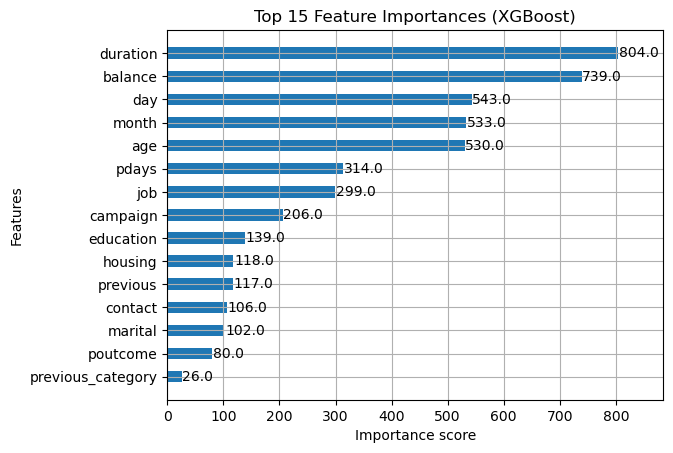

In [13]:
# Train an individual XGBoost model (for visualization and interpretation)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=15, importance_type='weight', height=0.5)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

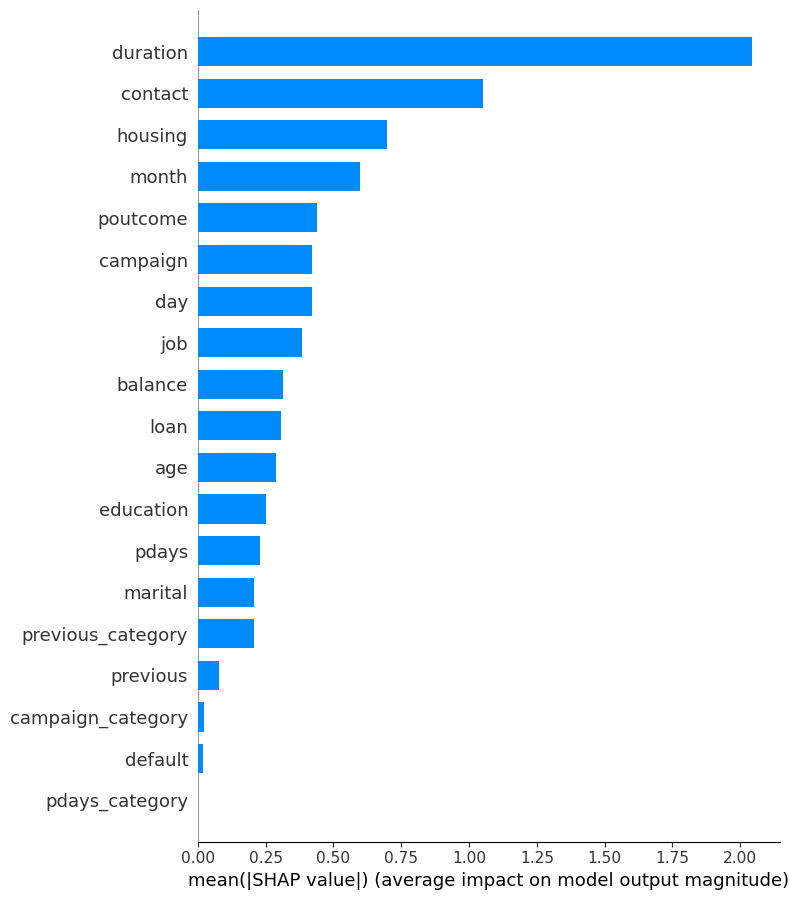

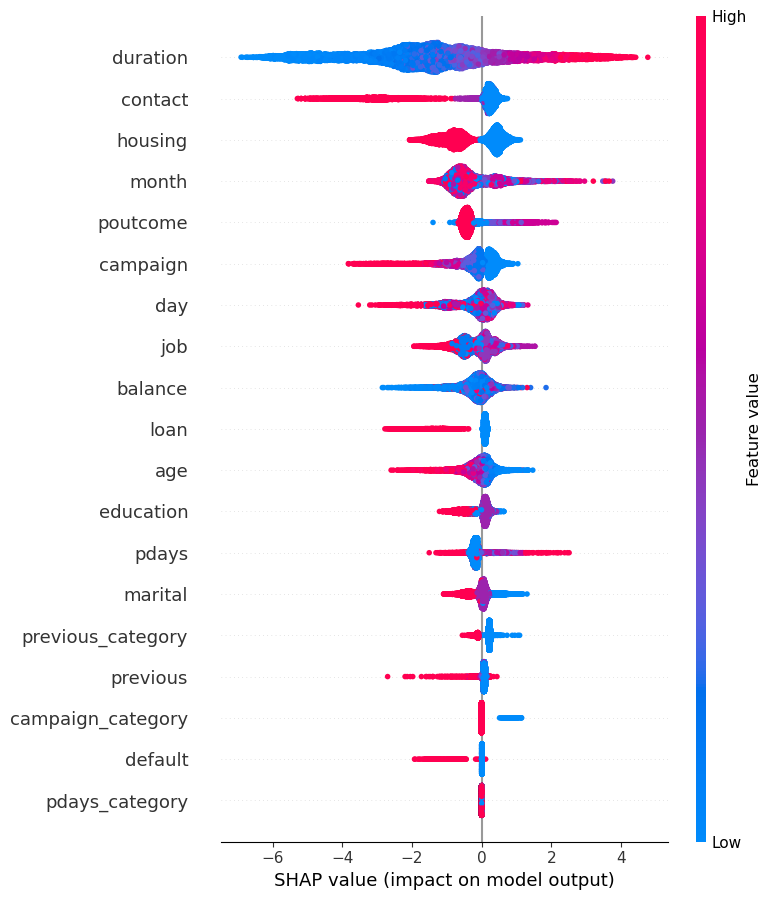

In [14]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Plot global feature importance (summary bar plot)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Plot feature impact on each individual sample (beeswarm plot)
shap.summary_plot(shap_values, X_test)

# Visualize SHAP explanation for a single sample prediction
shap.initjs()  # Initialize interactive JS visualization
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

after feature selection

Average MCC (Cross-Validation): 0.8209177069973231
Confusion Matrix of the Last Fold:
[[4997  594]
 [ 358 5233]]
Test Set MCC: 0.5096423033173276
Test Set Confusion Matrix:
[[10740  1226]
 [  479  1119]]


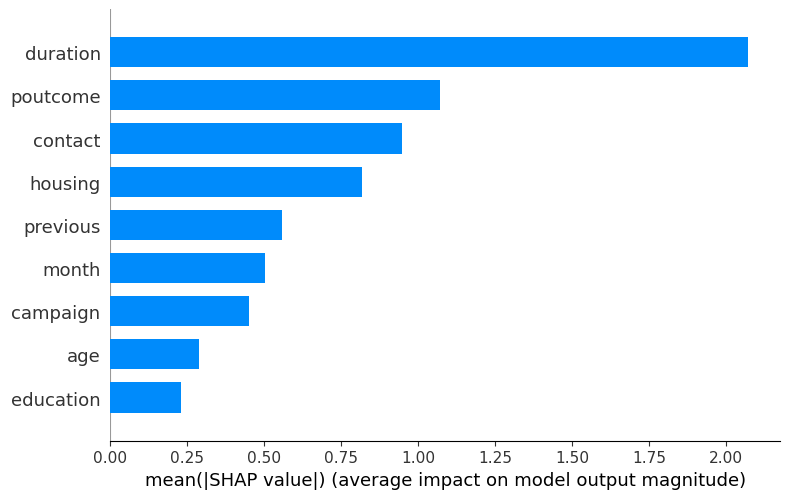

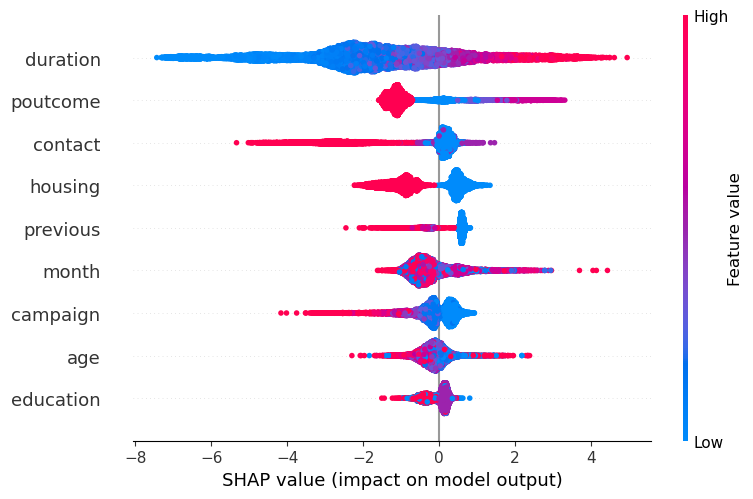

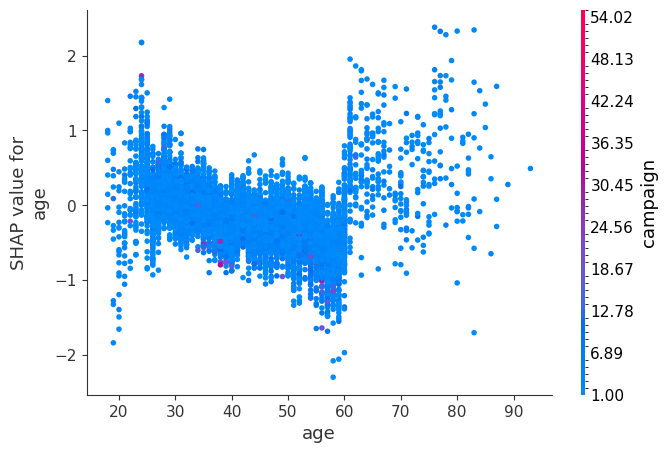

In [15]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import shap
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("C:\\Users\\立早\\Desktop\\bank_full_processed.csv")

# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Target variable
y = df['y']

# Select important features
selected_features = [
    'duration',
    'housing',
    'poutcome',
    'month',
    'contact',
    'previous',
    'campaign',
    'age',
    'education'
]

X = df[selected_features]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# XGBoost model (without use_label_encoder)
xgb_model = XGBClassifier(eval_metric='logloss')

# 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mcc_scores = []
conf_matrices = []

for train_index, val_index in kf.split(X_train_resampled, y_train_resampled):
    X_train_fold = X_train_resampled.iloc[train_index]
    X_val_fold = X_train_resampled.iloc[val_index]
    y_train_fold = y_train_resampled.iloc[train_index]
    y_val_fold = y_train_resampled.iloc[val_index]

    xgb_model.fit(X_train_fold, y_train_fold)
    y_pred = xgb_model.predict(X_val_fold)
    mcc_scores.append(matthews_corrcoef(y_val_fold, y_pred))
    conf_matrices.append(confusion_matrix(y_val_fold, y_pred))

print("Average MCC (Cross-Validation):", np.mean(mcc_scores))
print("Confusion Matrix of the Last Fold:")
print(conf_matrices[-1])

# Evaluate on the test set
y_test_pred = xgb_model.predict(X_test)
print("Test Set MCC:", matthews_corrcoef(y_test, y_test_pred))
print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# SHAP analysis
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Global feature importance (bar plot)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Feature impact across all samples (beeswarm plot)
shap.summary_plot(shap_values, X_test)

# Interactive explanation for a single sample
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

# Feature dependence plot
shap.dependence_plot("age", shap_values, X_test)
